# 패키지 로딩 및 환경 준비

In [2]:
# 필요한 기본 패키지 준비
%matplotlib inline
import numpy as np
import pandas as pd
from plotnine import *
import folium
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
import datetime as dt

# 한글 처리
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# jupyter notebook에서 warning 무시하기
import warnings
warnings.filterwarnings("ignore")

# 데이터 로딩 및 열(column) 순서 정렬

In [33]:
# 데이터 불러오기
gs = pd.read_csv('d:/project/contest/data/original/korea_cvs.csv')
lavla = pd.read_csv('d:/project/contest/data/original/korea_hnb.csv')
weather = pd.read_csv('d:/project/contest/data/original/20160101_20181231_cities.csv')

# 컬럼네임 짧게 변형
gs.columns = ['시도','판매일','성','나이','물품','수량','시군구']
lavla.columns = ['시도','시군구','판매일','성별','나이','물품','수량']

# 개인적인 편의를 위해 열(column)순서 변경
# gs및 lavla의 column순서가 동일하게 됨.
# 시, 구, 구매일, 성별, 나이, 물품, 수량 순으로 변경
gs = gs.iloc[:,[0,6,1,2,3,4,5]]

# 날씨 데이터 순서 변경
# loc	date	temp	rain	snow	cloud	wind	humid	hpa	sun_time	lgt_time	sun_energy
# 지점, 날짜, 온도, 강수량, 적설량, 구름량, 풍속, 습도, 기압, 해떠있는 시간, 
#                                                     햇빛이 땅에 닿은시간, 제곱미터당 (태양)에너지 도달량
weather = weather.iloc[:,[0,1,2,3,11,4,5,6,7,8,9,10]]
weather.columns = ['지역','날짜','온도','비','눈','구름','바람','습도','기압','가조시간','일조시간','합계일사']
# 내가 원하는 순서대로 변경됨.

In [37]:
# 제대로 변경됬나 확인
# gs.head(2)
# lavla.head(2)
# weather.head(2)

,지역,날짜,온도,비,눈,구름,바람,습도,기압,가조시간,일조시간,합계일사
0,108,2016-01-01,1.2,NaN,7.0,1.6,73.0,1019.9,9.6,2.1,4.61,NaN
1,108,2016-01-02,5.7,NaN,7.8,2.0,76.9,1012.0,9.6,3.6,4.50,NaN


# 데이터 전처리

데이터 전처리는 그냥 개인이 원하는 대로 처리하면 된다.
일관성 있게 처리만 해주면 된다!
예) 한 데이터셋에서 날짜를 str로 했다면 다른 데이터셋에서도 날짜는 str으로 통일 하는 식으로...

In [18]:
# 날씨데이터 정제

# 참고 : 날씨데이터에는 날짜가 string객체, yyyy-mm-dd형태로 들어와 있음
# 년/월/일/요일 추가
# 향후 작업을 편히 하기 위함, year, month, day 컬럼 생성

# 그냥 아무생각없이 int32타입으로 함. 원한다면 다른타입으로해도 상관없음
#   주의 할점은, 여기서 str으로 했다면 전부str, int로 했다면 전부int, datetime이면 전부 datetime으로
# gs편의점이나 랄라블라의 데이터셋에서도 같은 타입으로 설정 해주어야 편해진다.
weather['년'] = weather['날짜'].str.split('-',expand=True)[0].astype('int32')
weather['월'] = weather['날짜'].str.split('-',expand=True)[1].astype('int32')
weather['일'] = weather['날짜'].str.split('-',expand=True)[2].astype('int32')
weather['요일']=pd.to_datetime(weather['날짜']).apply(pd.datetime.weekday)
# string 날짜를 pd.datetime으로 
weather['날짜'] = pd.to_datetime(weather['날짜'])
weather['주'] = weather['날짜'].dt.week

In [31]:
# gs/lavla 날짜는 숫자로 들어와 있음

# gs데이터 정제 : 년/월/일/요일 추가
# 정수 나눗셈, 소숫점이하 버림 예) 20161225 // 10000 = 2016
gs['년'] = gs['판매일'] // 10000

# 년도를빼고 월일만 남겨둔뒤 월계산.
# 예) 20161212 -20160000 = 1225      1225 //100 = 12
gs['월'] = (gs['판매일'] - gs['년']*10000) // 100

# 년, 월 빼서 일 계산 
# 20161212 -2016*10000 - 12*100 - 25
gs['일'] = gs['판매일'] - gs['년']*10000 - gs['월']*100

# datetime 타입의 자료로 변화해서 'date'컬럼에 저장
# 현시점에선 year, month, day 컬럼이 맨오른쪽 3번째 부터 쭈르륵 나열 되어있음
gs['날짜'] = pd.to_datetime(gs.iloc[:,-3:])

# 참고 : 요일은 월요일(0)~일요일(6)의 숫자로 표현됨
gs['요일']=pd.to_datetime(gs['날짜']).apply(pd.datetime.weekday)

# 그 해를 시작하고 몇번째 주 인지 알려주는 컬럼 생성
gs['주']= gs['날짜'].dt.week

ValueError: to assemble mappings requires at least that [year, month, day] be specified: [day,month,year] is missing

In [32]:
# 랄라블라 데이터 정제 : 년/월/일/요일 추가
# 참고 : 요일은 월요일(0)~일요일(6)의 숫자로 표현됨

lavla['년'] = lavla['판매일'] // 10000
lavla['월'] = (lavla['판매일'] - lavla['년']*10000) // 100
lavla['일'] = lavla['판매일'] - lavla['년']*10000 - lavla['월']*100
lavla['날짜'] = pd.to_datetime(lavla.iloc[:,-3:])
lavla['요일']=pd.to_datetime(lavla['날짜']).apply(pd.datetime.weekday)
lavla['주'] = lavla['날짜'].dt.week

ValueError: to assemble mappings requires at least that [year, month, day] be specified: [day,month,year] is missing

## 결측치 처리

In [117]:
# 결측치가 넘쳐나는것을 발견. 의미 없는 데이터가 될 것으로 판단됨. 제거.
weather=weather.drop(columns=['sun_energy'])

In [118]:
# 부산(143) 2017/07/29일의
# 구름량(8초과), 비오는날(강수량 0초과), 습도(80초과), 기압(1002초과), 여름계절(6~9월달) 조건과 비슷한
# 부산 지역의 2017/07월 평균 값으로 대체하기 위한 평균 기온 계산
weather.loc[(weather['cloud']>8) 
            & (weather['rain']>0) 
            & (weather['humid']>80) 
            & (weather['hpa']>1002)
            & (weather['month'].between(6,9, inclusive=True))
            & (weather['loc']==143), ['loc','temp','year','month']].groupby(['loc','year','month']).mean()

temp
loc year month           
143 2016 6      20.150000
         7      23.900000
         9      21.554545
    2017 7      25.966667
         8      25.566667
         9      21.400000
    2018 6      22.700000
         7      22.800000
         8      23.275000
         9      21.025000

In [119]:
# 부산 지역의 7월 평균 값으로 대체
# 25.96 약 26도
# 3683은 사전에 결측치로 확인해서 미리 찾아둠 행(row)위치 찾음.
weather.loc[3863,'temp'] = 26.0

In [120]:
# 강수량및 적설량의 결측치는 비/눈이 오지 않은것이라 판단 0으로 대체
weather.loc[weather['rain'].isna(),'rain'] = 0
weather.loc[weather['snow'].isna(),'snow'] = 0

# 총 일조시간은 극적인 변화를 보이지 않을 것이라 판단 결측치 바로 전날 값으로 채우기로 결정
weather['lgt_time']=weather['lgt_time'].fillna(method='ffill')
# method='ffill'  : forward fill인가 그 비슷한 뜻으로 전값으로 넣겠다는 뜻

# 평균기압(hpa)은 극적인 변화를 보이지 않을 것이라 판단 결측치 바로 전날 값으로 채우기로 결정
weather['hpa']=weather['hpa'].fillna(method='ffill')

In [121]:
# 풍속(wind) 결측치가 포함된 달의 평균풍속으로 대체

# print('2017/10의 평균 풍속', weather.loc[(weather['loc']==108)&(weather['year']==2017) & (weather['month']==10), 'wind'].mean())
# 1.9366666666666663
weather.loc[(weather['wind'].isna()) &(weather['year']==2017) & (weather['month']==10), 'wind'] = 1.9

# print('2017/12의 평균 풍속', weather.loc[(weather['loc']==108)&(weather['year']==2017) & (weather['month']==12), 'wind'].mean() )
# 1.7827586206896548
weather.loc[(weather['wind'].isna()) &(weather['year']==2017) & (weather['month']==12), 'wind'] = 1.8

# print('2018/07의 평균 풍속', weather.loc[(weather['loc']==112)&(weather['year']==2018) & (weather['month']==7), 'wind'].mean() )
# 1.6903225806451612
weather.loc[(weather['wind'].isna()) & (weather['year']==2018) & (weather['month']==7), 'wind'] = 1.7

In [122]:
# 결측치 확인
weather.isnull().sum()
# 결측치 제거 확인

loc         0
date        0
temp        0
rain        0
cloud       0
wind        0
humid       0
hpa         0
sun_time    0
lgt_time    0
snow        0
year        0
month       0
day         0
weekday     0
nth_week    0
dtype: int64

## 데이터 중간 저장

In [123]:
gs.to_csv('d:/project/contest/data/processed/p_gs.csv', index=False, encoding='utf-8')
lavla.to_csv('d:/project/contest/data/processed/p_lavla.csv', index=False, encoding='utf-8')
weather.to_csv('d:/project/contest/data/processed/p_weather.csv', index=False, encoding='utf-8')
print('saving done!')

saving done!


## 데이터 기본 정보 확인

In [ ]:
gs.info() # 270만
lavla.info() # 82만
weather.info() # 7672

## 기본적인 시각화

In [220]:
# 데이터 불러오기
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv')
lavla = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv')
weather = pd.read_csv('d:/project/contest/data/processed/p_weather.csv')

In [221]:
# 일단 서울(108)만
w_2016 = weather.loc[weather['year']==2016,['loc','date','temp','month','nth_week']]
seoul_2016 = w_2016.loc[w_2016['loc']==108]
seoul_2016.tail(2)

,loc,date,temp,month,nth_week
364,108,2016-12-30,-3.9,12,52
365,108,2016-12-31,0.7,12,52


In [222]:
# 왜 366일인지 확인 해본결과, 윤년!!
#날짜 중복 확인 : False
print(seoul_2016['date'].duplicated().any())

# 2/28일 확인 : 윤년!
seoul_2016.loc[seoul_2016['date']=='2016-02-28']
# seoul_2016.loc[seoul_2016['nth_week']==53]
# seoul_2016.groupby('nth_week').count()

False


,loc,date,temp,month,nth_week
58,108,2016-02-28,0.7,2,8


In [223]:
lavla[['date','year','month','nth_week']].loc[(lavla['year']==2018)&(lavla['month']==12)]['nth_week'].unique()

array([48, 49, 50, 51, 52,  1], dtype=int64)

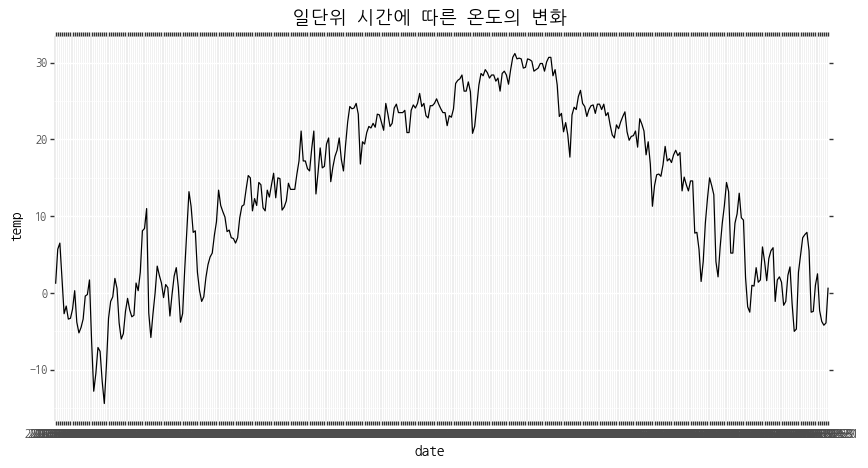

<ggplot: (-9223371884914446448)>

In [224]:
( 
ggplot(seoul_2016)+
    aes(x='date', y="temp", group=1)+
    geom_line()+
    ggtitle('일단위 시간에 따른 온도의 변화')+
    theme(text=element_text(family='NanumGothicCoding'), figure_size = (10,5))
)

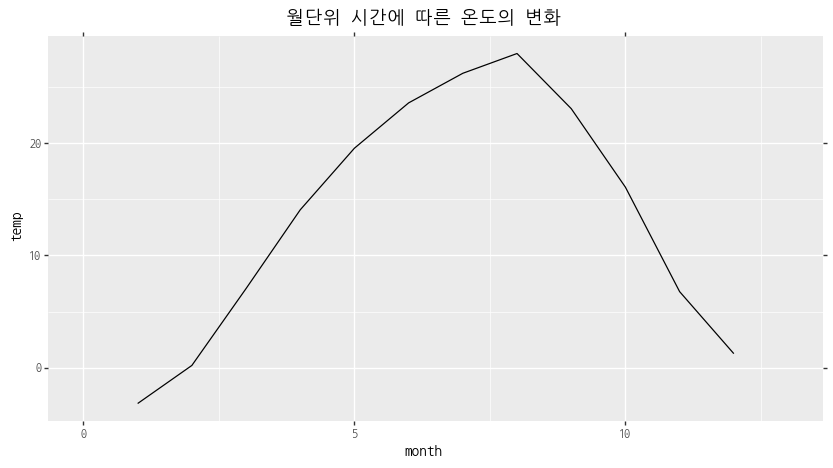

<ggplot: (151940460082)>

In [225]:
w_seoul_2016_month = pd.DataFrame(seoul_2016[['month','temp']]\
            .groupby(by=['month']).mean().reset_index())
( 
ggplot(data=w_seoul_2016_month)
    + aes(x='month', y="temp", group=1)
    +geom_line()
    +ggtitle('월단위 시간에 따른 온도의 변화')
    +theme(text=element_text(family='NanumGothicCoding'), figure_size = (10,5))
    +xlim(0,13)
)

In [226]:
# 서울특별시만
w_seoul_2016_month = pd.DataFrame(seoul_2016[['month','temp']]\
            .groupby(by=['month']).mean().reset_index())
gs_seoul = gs.loc[gs['pvn_nm']=='서울특별시']

# 2016년, 아이스크림, 월단위로
ice_2016 = pd.DataFrame(gs_seoul.loc[(gs_seoul['year']==2016), ['month','category','qty']]\
            .groupby(by=['month','category']).sum().reset_index())

# 판매량 단위 조정 : 만단위로
ice_2016['qty_scale'] = ice_2016['qty'].apply(lambda x : x/10000)

In [227]:
# 다른 방법도 있겟지만, 평균기온과 판매량을 표기 하기 위해 데이터 셋을 merge(SQL의 join과 비슷한 함수)
# 2016년 아이스크림 테이블
df_joined = pd.merge(ice_2016, w_seoul_2016_month[['month','temp']], how='inner', on='month')

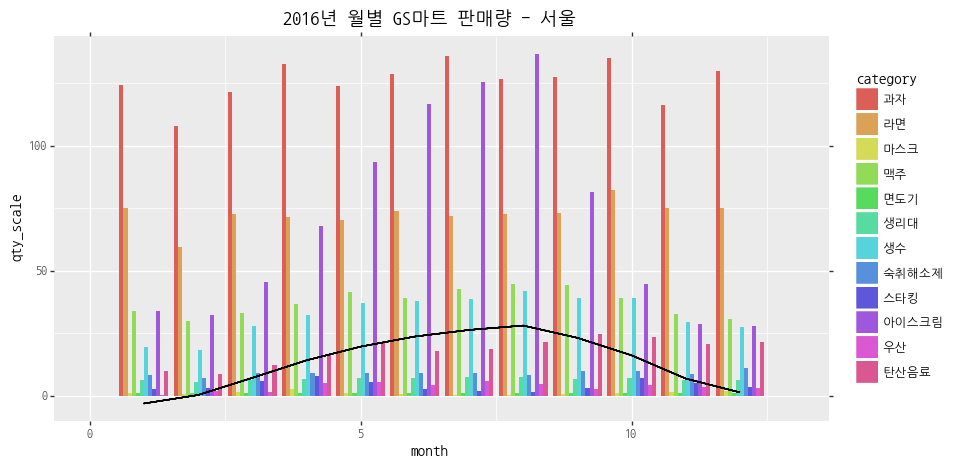

<ggplot: (151940280524)>

In [228]:
(ggplot(df_joined, aes(x='month',y='qty_scale',fill='category'))
+ geom_bar(stat='identity',position='dodge')
+ geom_line(aes(x='month',y='temp'))
+ ggtitle('2016년 월별 GS마트 판매량 - 서울')
+ theme(text=element_text(family='NanumGothicCoding'), figure_size = (10,5))
+ xlim(0,13)
)

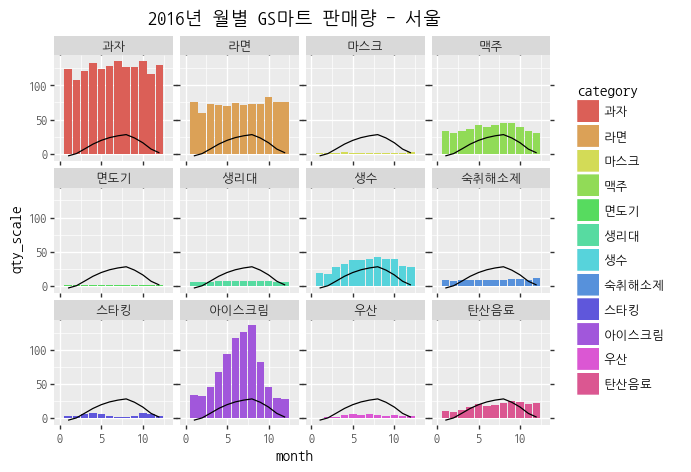

<ggplot: (151940864432)>

In [229]:
(ggplot(df_joined, aes(x='month',y='qty_scale',fill='category'))
+ geom_bar(stat='identity',position='dodge')
+ geom_line(aes(x='month',y='temp'))
+ ggtitle('2016년 월별 GS마트 판매량 - 서울')
+ facet_wrap('category')
# + theme(text=element_text(family='NanumGothicCoding'), figure_size = (10,5))
+ theme(text=element_text(family='NanumGothicCoding'))
+ xlim(0,13)
)

### y축이 두개인 그래프 
https://stackoverflow.com/questions/38810009/matplotlib-plot-bar-and-line-charts-together

# 2019/06/27

### 월단위 분석 평가
* 주단위 분석의 필요성 확인
* 스케일 문제 해결 방안 필요


* 아이스크림 관계성 확실해 보임
* 생수/맥주/탄산음료 : 있어보임
* 과자/라면/생리대/숙취해소제 : 딱히 온도와 관련이 없어보임
* 마스크/면도기/우산/스타킹 : 스케일 재조정후 분석 필요

In [230]:
# 서울특별시만 : 주 단위로
w_seoul_2016_week = pd.DataFrame(seoul_2016[['nth_week','temp']]\
            .groupby(by=['nth_week']).mean().reset_index())
gs_seoul = gs.loc[gs['pvn_nm']=='서울특별시']

# 2016년, 아이스크림, 주단위로
ice_2016 = pd.DataFrame(gs_seoul.loc[(gs_seoul['year']==2016), ['nth_week','category','qty']]\
            .groupby(by=['nth_week','category']).sum().reset_index())

# 판매량 단위 조정 : 만단위로
ice_2016['qty_scale'] = ice_2016['qty'].apply(lambda x : x/10000)

# 다른 방법도 있겟지만, 평균기온과 판매량을 표기 하기 위해 데이터 셋을 merge(SQL의 join과 비슷한 함수)
df_joined = pd.merge(ice_2016, w_seoul_2016_week[['nth_week','temp']], how='inner', on='nth_week')

## 주단위로!

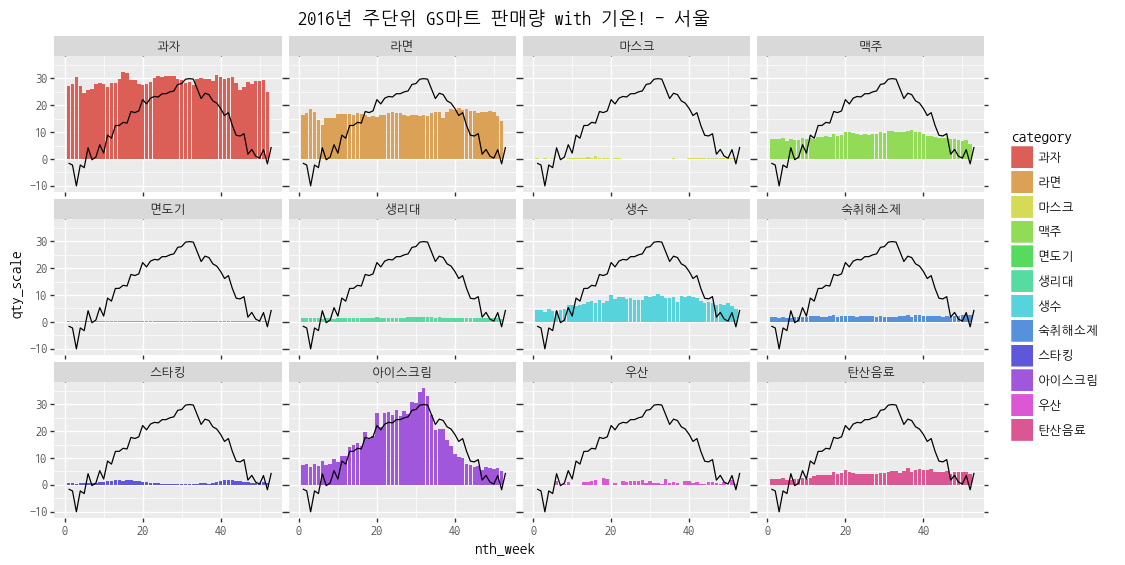

<ggplot: (-9223371884914422177)>

In [231]:
(ggplot(df_joined, aes(x='nth_week',y='qty_scale',fill='category'))
+ geom_bar(stat='identity',position='dodge')
+ geom_line(aes(x='nth_week',y='temp'))
+ ggtitle('2016년 주단위 GS마트 판매량 with 기온! - 서울')
+ facet_wrap('category')
+ theme(text=element_text(family='NanumGothicCoding'), figure_size = (12,6))
+ xlim(0,53)
)

### 샘플링을 하기 위해 작은 데이터만 추출해서 시각화 해봄

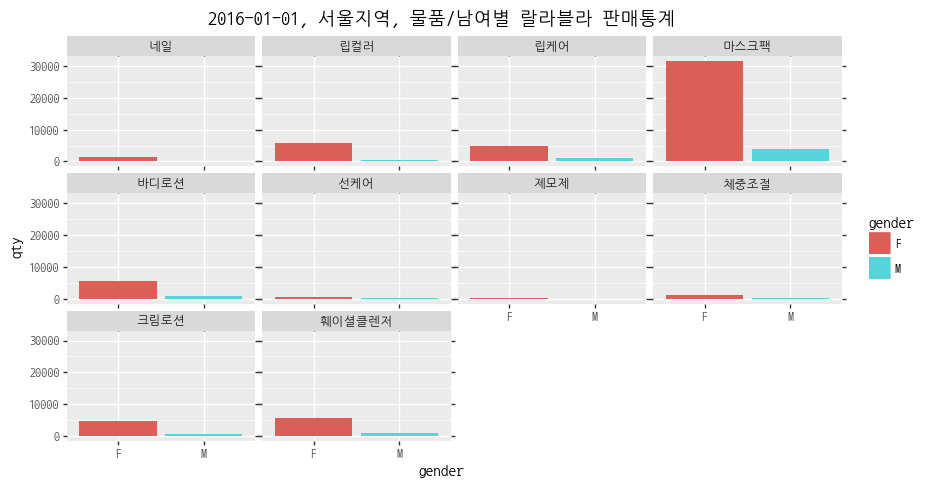

<ggplot: (151950467648)>

In [232]:
# 랄라블라에서 필요한 데이터만 추출
lalavla = lavla[['pvn_nm','date','gender','age_cd','category','qty']]

# 지역 =서울특별시, 날짜=2016-01-01로 한정
lalavla_seoul = lalavla.loc[(lalavla['pvn_nm']=='서울특별시')&(lalavla['date']=='2016-01-01')]

# 그룹화를 통한 일+물품+성별 합계 구해서 새로운 변수에 reset_index()해서 저장
df = lalavla_seoul[['date','gender','category','qty']].groupby(by=['date','gender','category']).sum().reset_index()

# 간단한 시각화
(ggplot(df, aes(x='gender',y='qty',fill='gender'))
+ geom_bar(stat='identity',position='dodge')
+ ggtitle('2016-01-01, 서울지역, 물품/남여별 랄라블라 판매통계')
+ facet_wrap('category')
+ theme(text=element_text(family='NanumGothicCoding'), figure_size = (10,5))
)

# 2019/06/28 금

In [8]:
print(gs.columns)
print(lavla.columns)
print(weather.columns)

Index(['pvn_nm', 'bor_nm', 'sale_dt', 'gender', 'age_cd', 'category', 'qty',
       'year', 'month', 'day', 'date', 'weekday', 'nth_week'],
      dtype='object')
Index(['pvn_nm', 'bor_nm', 'sale_dt', 'gender', 'age_cd', 'category', 'qty',
       'year', 'month', 'day', 'date', 'weekday', 'nth_week'],
      dtype='object')
Index(['loc', 'date', 'temp', 'rain', 'cloud', 'wind', 'humid', 'hpa',
       'sun_time', 'lgt_time', 'snow', 'year', 'month', 'day', 'weekday',
       'nth_week'],
      dtype='object')


In [10]:
gs.loc[gs['pvn_nm']=='경기도','bor_nm'].unique()

array(['수원시', '성남시', '의정부시', '안양시', '부천시', '광명시', '안산시', '고양시', '과천시',
       '구리시', '남양주시', '시흥시', '군포시', '의왕시', '하남시', '용인시', '파주시', '김포시',
       '화성시', '광주시', '오산시안성시평택시', '양주시', '동두천시', '연천군포천군', '가평군양평군',
       '여주시이천시'], dtype=object)

In [233]:
gs_day = gs.iloc[:,[0,1,3,4,5,6,7,8,9,10,11,12]]
gs_day.iloc[:,[6,7,8,10]] = gs_day.iloc[:,[6,7,8,10]].astype('str')
gs_day = gs_day.groupby(by=['day','pvn_nm','bor_nm','category']).sum()
gs_day = gs_day.reset_index()

In [234]:
gs_week = gs.iloc[:,[0,1,3,4,5,6,7,8,9,10,11,12]]
gs_week.iloc[:,[6,7,8,10]] = gs_week.iloc[:,[6,7,8,10]].astype('str')
gs_week = gs_week.groupby(by=['nth_week','pvn_nm','bor_nm','category']).sum()
gs_week = gs_week.reset_index()

In [235]:
gs_day.head()
gs_week.head()

,nth_week,pvn_nm,bor_nm,category,qty
0,1,경기도,가평군양평군,과자,9498
1,1,경기도,가평군양평군,라면,6379
2,1,경기도,가평군양평군,마스크,196
3,1,경기도,가평군양평군,맥주,2125
4,1,경기도,가평군양평군,면도기,70


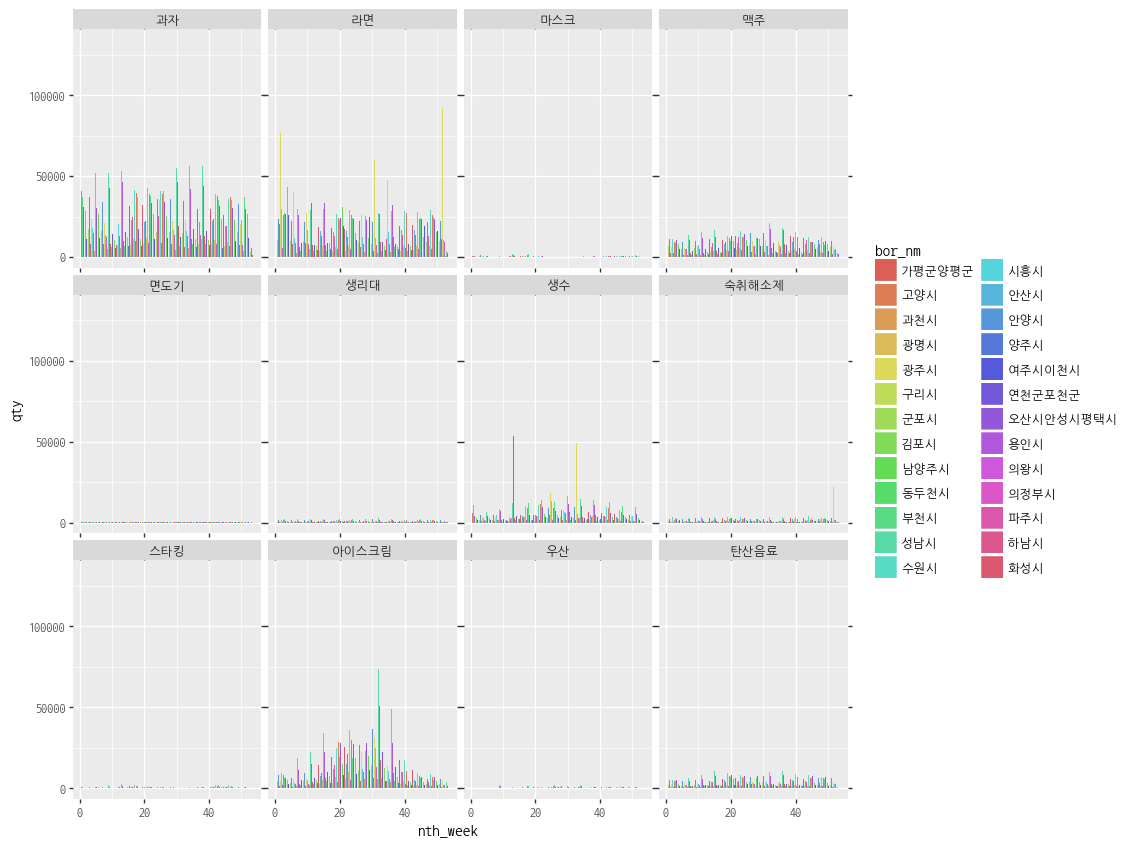

<ggplot: (-9223371884914429254)>

In [236]:
# 간단한 시각화
(ggplot(gs_week.loc[(gs_week['pvn_nm']=='경기도')], aes(x='nth_week',y='qty',fill='bor_nm'))
+ geom_bar(stat='identity',position='dodge')
# + ggtitle('2016~2018, 지역별 판매량')
+ facet_wrap('category')
+ theme(text=element_text(family='NanumGothicCoding'), figure_size = (10,10))
)

In [237]:
gs_umbrella = gs.loc[gs['category']=='우산']
gs_umbrella = gs_umbrella.iloc[:,[0,1,3,4,5,6,7,8,9,10,11,12]]
gs_umbrella.iloc[:,[6,7,8,10]] = gs_umbrella.iloc[:,[6,7,8,10]].astype('str')
gs_umbrella = gs_umbrella.groupby(by=['nth_week','pvn_nm','bor_nm','category']).sum()
gs_umbrella = gs_umbrella.reset_index()

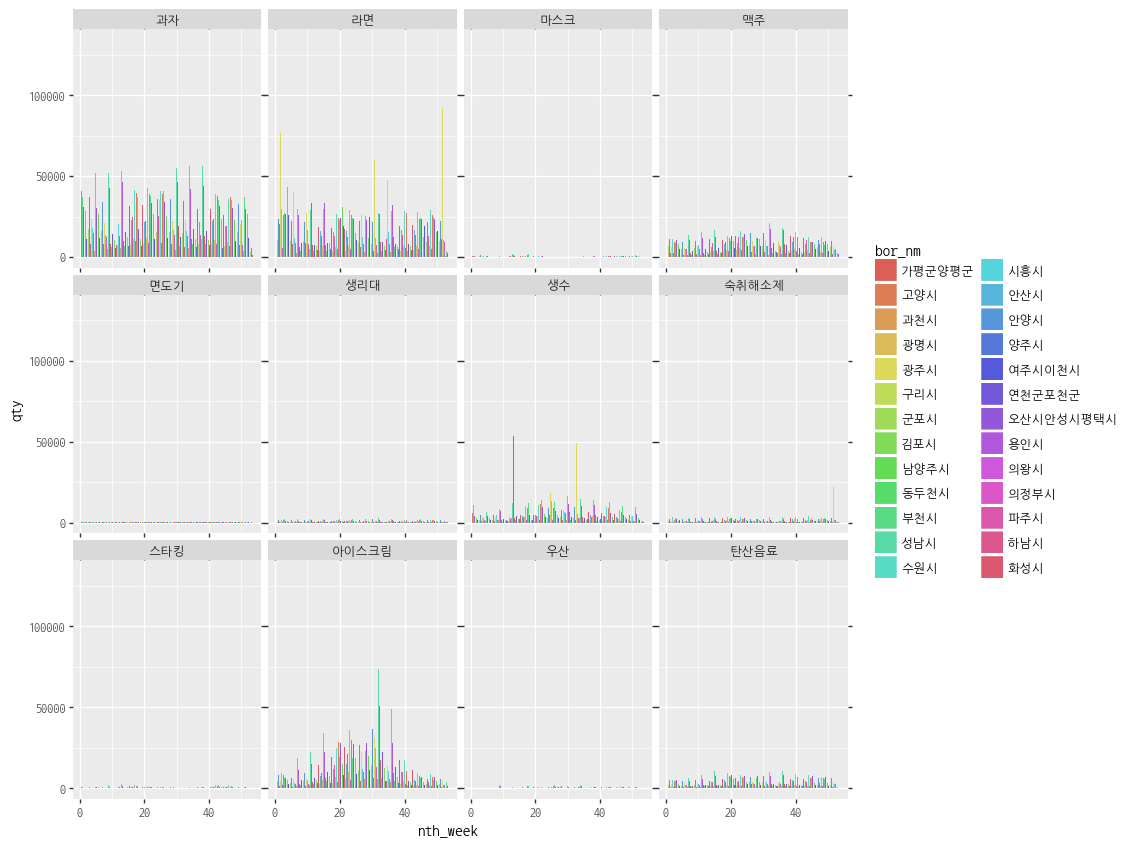

<ggplot: (151950289209)>

In [238]:
(ggplot(gs_week.loc[(gs_week['pvn_nm']=='경기도')], aes(x='nth_week',y='qty',fill='bor_nm'))
+ geom_bar(stat='identity',position='dodge')
# + ggtitle('2016~2018, 지역별 판매량')
+ facet_wrap('category')
+ theme(text=element_text(family='NanumGothicCoding'), figure_size = (10,10))
)

In [239]:
w_tf = weather.copy()
w_tf['rn_t'] = w_tf['rain'].apply(lambda x : 1 if x>0 else 0)
w_tf['sn_t'] = w_tf['snow'].apply(lambda x : 1 if x>0 else 0)
w_tf['precip']=(w_tf['rain']+w_tf['snow']).apply(lambda x : 1 if x>0 else 0)
w_tf.drop(columns=['rn_t','sn_t'], inplace=True)
w_tf.head()
w_tf_week_seoul = w_tf.loc[w_tf['loc']==108,['nth_week','precip']].groupby('nth_week').sum().reset_index()
w_tf_week_seoul.tail(2)

,nth_week,precip
51,52,4
52,53,0


In [240]:
# w_tf.loc[w_tf['loc']==108,['nth_week','precip']].groupby('nth_week').sum()
# sample = w_tf.loc[w_tf['loc']==108,['nth_week','precip']]
# sample.loc[sample['nth_week']==28]
# weather.loc[(weather['nth_week']==28)&(weather['loc']==108)&(weather['date'].dt.startwith('2016-'))]

In [241]:
gs_umbrella_seoul = gs_umbrella.loc[gs_umbrella['pvn_nm']=='서울특별시']
gs_umbrella_seoul.tail(3)

,nth_week,pvn_nm,bor_nm,category,qty
3083,53,서울특별시,성북구,우산,7
3084,53,서울특별시,양천구,우산,14
3085,53,서울특별시,중구,우산,7


## Logistic Regression을 통한 판매량 예측

혹은 결과를 카테고리화 해서 하락세/상승세/현상유지 할것이다를 예측?

In [26]:
# w_seoul = weather.loc[weather['loc']==108,['date','temp']]
# df = lavla.loc[lavla['year']==2016]

In [30]:
# df2 = df.merge(w_seoul, how='left', on='date')
# df2.drop(columns=['bor_nm', 'sale_dt'], inplace=True)

In [37]:
# df3 = df2[['nth_week','gender','category','qty']].groupby(by=['nth_week','gender','category']).sum().reset_index()

In [46]:
# # 간단한 시각화
# (ggplot(df3, aes(x='nth_week',y='qty',fill='category'))
# + geom_bar(stat='identity',position='dodge')
# + facet_wrap('gender')
# + theme(text=element_text(family='NanumGothicCoding'), figure_size = (10,10))
# )

SyntaxError: positional argument follows keyword argument (<ipython-input-46-dee356a433a3>, line 4)

# 일단 할수 있는거 부터 
## 상관관계가 뚜렷한 아이스크림 판매량 분석

In [242]:
# gs,서울,아이스크림, 2016~2018
col_to_use = ['pvn_nm','gender','qty','date','category']
gs_seoul_ice_all = gs.loc[(gs['category']=='아이스크림')&(gs['pvn_nm']=='서울특별시')]
df1 = gs_seoul_ice_all[col_to_use].groupby(by=['date','pvn_nm','category']).sum().reset_index()
# gs_seoul_ice_train[col_to_use].groupby(by=['date']).sum()
# df1.info()

In [243]:
# www = weather.loc[(weather['loc']==108)&(weather['year']==2016),['date','temp','humid','wind','rain','snow','cloud']]
# www.tail()
w_s_all = weather.loc[(weather['loc']==108),['date','temp','humid','wind','rain','snow','cloud']]
# w_s_train.info()

In [244]:
df1_w_s_all = pd.merge(df1, w_s_all, on='date', how='left')
df1_w_s_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1096 entries, 0 to 1095
Data columns (total 10 columns):
date        1096 non-null object
pvn_nm      1096 non-null object
category    1096 non-null object
qty         1096 non-null int64
temp        1096 non-null float64
humid       1096 non-null float64
wind        1096 non-null float64
rain        1096 non-null float64
snow        1096 non-null float64
cloud       1096 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 94.2+ KB


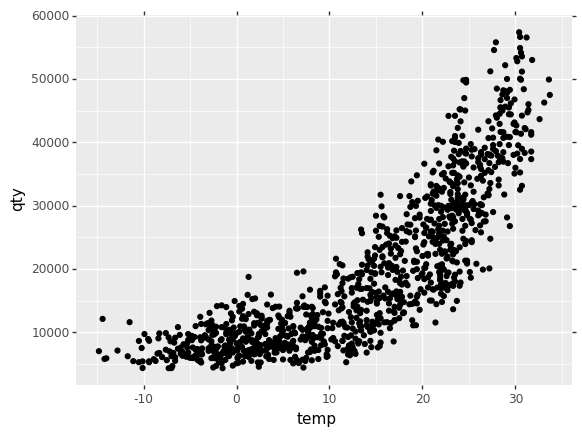

<ggplot: (-9223371884809916819)>

In [245]:
# gs,서울,아이스크림, 2016~2018년
(
    ggplot(df1_w_s_all)
    + aes(x='temp', y='qty')
    + geom_point()
)

In [246]:
df1_w_s_all['date'] = pd.to_datetime(df1_w_s_all['date'])
using_cols=['date','temp','humid','wind','rain','snow','cloud','qty']
df_train = df1_w_s_all.loc[(df1_w_s_all['date']<='2017-12-31'), using_cols]
df_test = df1_w_s_all.loc[(df1_w_s_all['date']>='2018-01-01'), using_cols]
# print(df_train.tail(1))
# print(df_test.head(1))
df_train_data = df_train.iloc[:,1:-1]
df_train_target = df_train.iloc[:,7]
df_test_data = df_test.iloc[:,1:-1]
df_test_target = df_test.iloc[:,7]

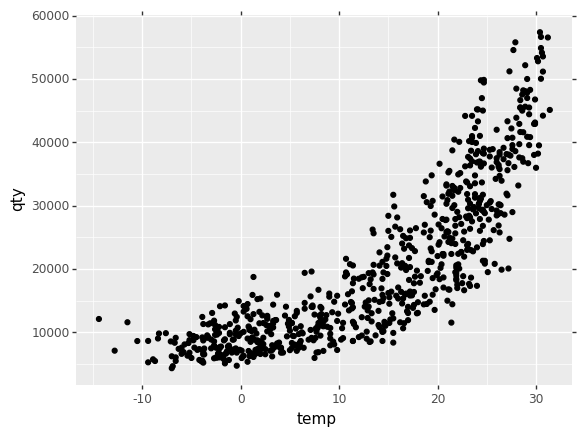

<ggplot: (-9223371884898998766)>

In [247]:
(
    ggplot(df_train)
    + aes(x='temp', y='qty')
    + geom_point()
)

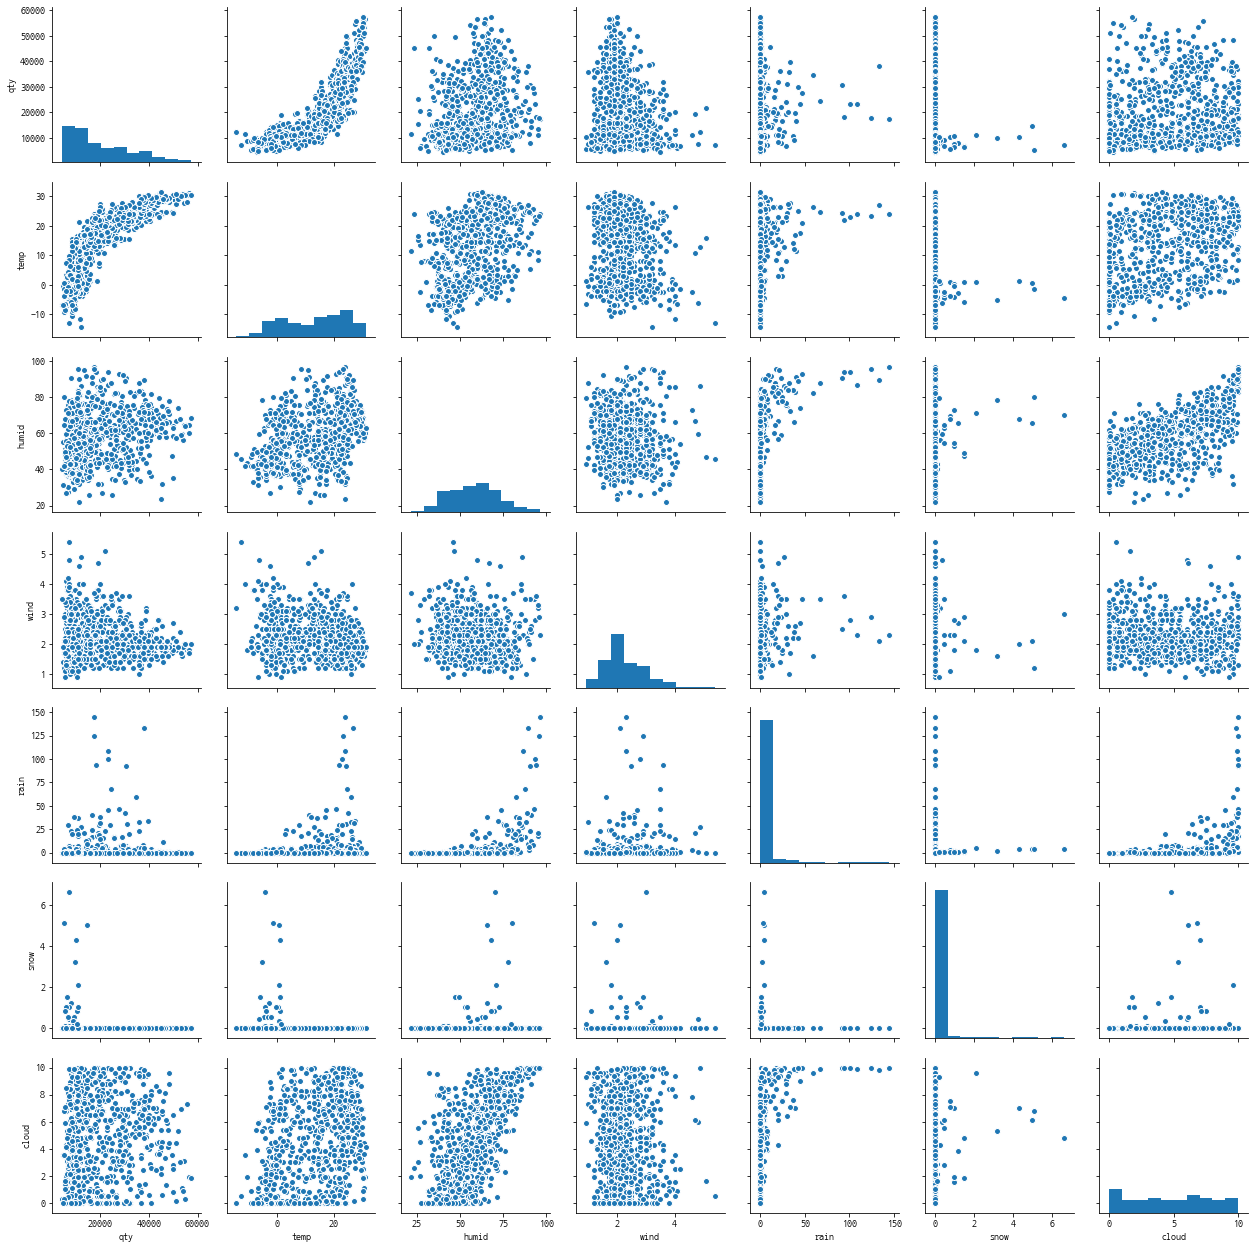

In [105]:
import seaborn as sns
cols = ['qty','temp','humid','wind','rain','snow','cloud']
sns.pairplot(df_train[cols])

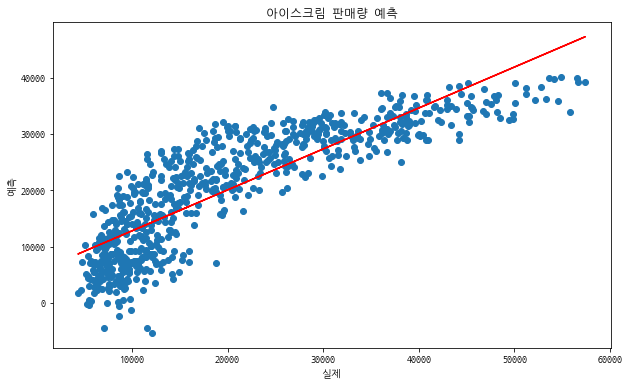

In [248]:
# sklearn을 이용한 회귀분석
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.model_selection import train_test_split

# 13개의 특성으로 훈련결과의 모델(회귀분석 모델)
model = LinearRegression().fit(df_train_data, df_train_target)
predicted = model.predict(df_train_data) # 13개의 특성치로 주택가격을 예측
plt.scatter(df_train_target, predicted)
plt.xlabel('실제')
plt.ylabel('예측')
plt.title('아이스크림 판매량 예측')
# plt.show()

# 회귀선
result = stats.linregress(df_train_target,predicted)
slope, intercept, r_value, p_value, std_err = result
x = np.array(df_train_target)
plt.plot(x, intercept+slope*x, c='red')
plt.show()

In [128]:
from sklearn.model_selection import train_test_split

X = df_train.iloc[:,1:-1]
y = df_train.iloc[:,7]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)

# fit() : 머신러닝 즉, 주어진 데이터를 가지고 기계학습을 시키는 명령
# 회귀분석모델에 데이터를 입력하여 기계학습 실시
model = LinearRegression().fit(X_train, y_train)
print(model)

# 훈련데이터셋
model.score(X_train, y_train) 
# 검증 데이터셋을 가지고 예측결과
model.score(df_test.iloc[:,1:-1], (df_test.iloc[:,7]))

print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

(511, 6) (220, 6)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
훈련세트점수 : 0.73
검증세트점수 : 0.73


In [157]:
from sklearn.linear_model import Ridge
X = df_train.iloc[:,1:-1]
y = df_train.iloc[:,7]

print(X_train.shape, X_test.shape)

# fit() : 머신러닝 즉, 주어진 데이터를 가지고 기계학습을 시키는 명령
# 회귀분석모델에 데이터를 입력하여 기계학습 실시
ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
print(ridge)

print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))

(511, 6) (220, 6)
Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=0, solver='auto', tol=0.001)
훈련세트점수 : 0.72
검증세트점수 : 0.72


In [255]:
# sm.OLS
import statsmodels.api as sm
experiment_mo = sm.OLS.from_formula("qty ~ temp + humid + wind + rain + snow + cloud", data=df_train)
# experiment_mo = sm.OLS.from_formula("qty ~ .", data=df_train)

experiment_mo.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    qty   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     325.1
Date:                Mon, 01 Jul 2019   Prob (F-statistic):          1.24e-201
Time:                        16:04:57   Log-Likelihood:                -7454.2
No. Observations:                 731   AIC:                         1.492e+04
Df Residuals:                     724   BIC:                         1.495e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9191.6519   1512.641      6.077      0.000    6221.965    1.22e+04
temp        1011.6240     24.669     41.008      0.000     963.193    1060.055
humid          8.9487     23.722      0.377      0.706     -37.623      55.520
wind        -150.8067    366.420     -0.412      0.681    -870.180     568.566
rain         -51.3339     20.832     -2.464      0.014     -92.232     -10.436
snow        1169.2688    572.610      2.042      0.042      45.094    2293.444
cloud       -520.4657    102.962     -5.055      0.000    -722.606    -318.325
==============================================================================
Omnibus:                        7.981   Durbin-Watson:                   0.389
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                8.115
Skew:                           0.257   Prob(JB):                       0.0173
Kurtosis:                       2.956   Cond. No.                         395.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

아이스크림은 확실히(당연하게도) 온도가 높을수록 판매량이 높아진다.

In [3]:
# 2016년 화장품 판매 데이터 분석
col_to_use = ['pvn_nm','gender','qty','date','category']
lavla_seoul_ice_2016 = lavla.loc[(lavla['year']==2016)&(lavla['pvn_nm']=='서울특별시')]
ddd = lavla_seoul_ice_2016[col_to_use].groupby(by=['date','category']).sum().reset_index()
ddd.tail()

,date,category,qty
3654,2016-12-31,선케어,1487
3655,2016-12-31,제모제,435
3656,2016-12-31,체중조절,872
3657,2016-12-31,크림로션,9758
3658,2016-12-31,훼이셜클렌저,7614


In [38]:
# 2016, weather데이터 추출 후 
www = weather.loc[(weather['loc']==108)&(weather['year']==2016),['date','temp','humid','wind','rain','snow','cloud']]
# 날짜기준으로 랄라블라2016년 데이터 셋과 겹합
dddwww = pd.merge(ddd, www, on='date', how='left')
# 판매량 스케일 조정
dddwww['scaled'] = dddwww['qty'].apply(lambda x : x/10000)
# 시각화 대비 날자데이터 컬럼 날짜로 변환
dddwww['date'] = pd.to_datetime(dddwww['date'])

# 마스크팩 판매량 제외 하고 분석 시도
dfdfdf = dddwww.loc[dddwww['category']!='마스크팩']

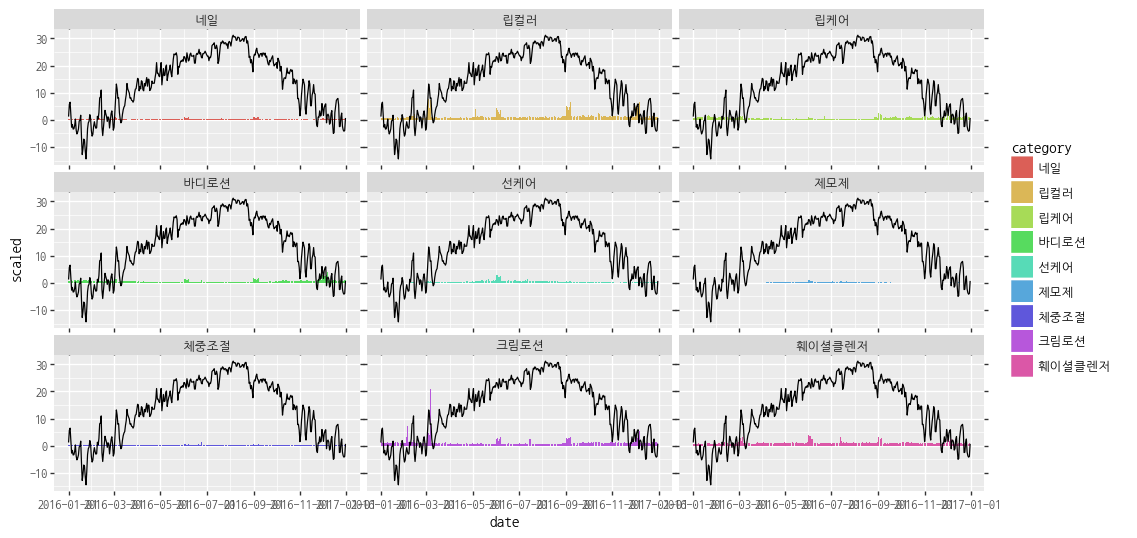

<ggplot: (-9223371884918416198)>

In [39]:
# 날짜에 따른 물품별 판매량
(ggplot(dfdfdf, aes(x='date',y='scaled',fill='category'))
+ geom_bar(stat='identity',position='dodge')
+ geom_line(aes(x='date',y='temp'))
+ facet_wrap('category')
+ theme(text=element_text(family='NanumGothicCoding'), figure_size = (12,6))
)

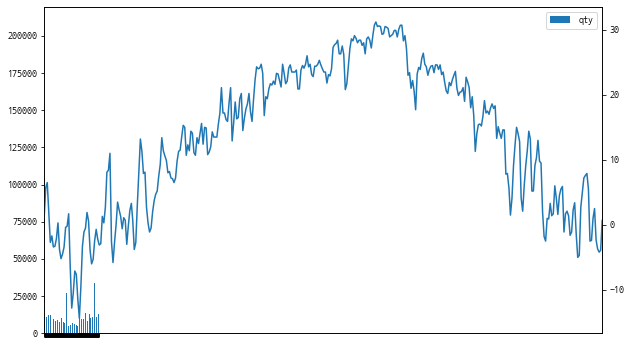

In [42]:
m1_t = dfdfdf.loc[dfdfdf['category']=='크림로션']

m1_t[['qty']].plot(kind='bar')
m1_t['temp'].plot(secondary_y=True)

matplotlib.rcParams['figure.figsize'] = (10, 6)
ax = plt.gca()
# plt.xlim([-width, len(m1_t['date'])-width])
# plt.figure(figsize=(10,6))
# ax.set_xticklabels(dfdfdf['date'])
ax.set_xticklabels('')
plt.show()

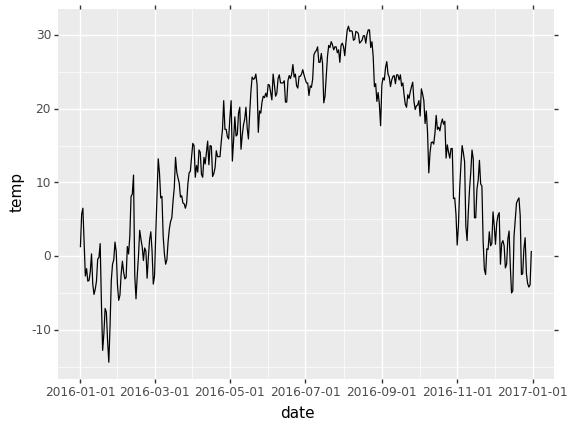

<ggplot: (151941058119)>

In [41]:
(ggplot(m1_t)
+aes(x='date',y='temp')
+geom_line()
)

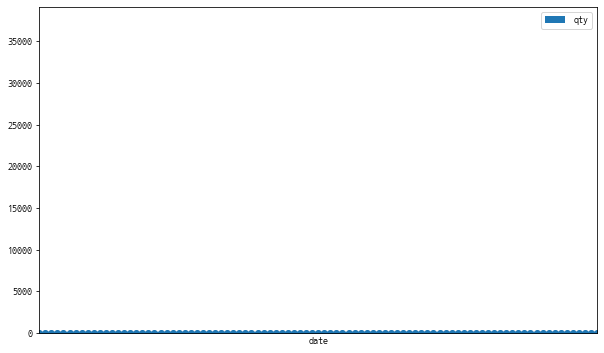

In [57]:
df=m1_t.loc[m1_t['date'].between('2016-06-01','2016-09-01'),['date','qty','scaled','temp']]
ax = df.loc[:,['date','qty']].plot(x='date',y='qty',kind='bar')
df.loc[:,'temp'].plot(linestyle='-', marker='o', ax = ax)
ax.set_xticklabels(df.date, rotation=40)
plt.show()

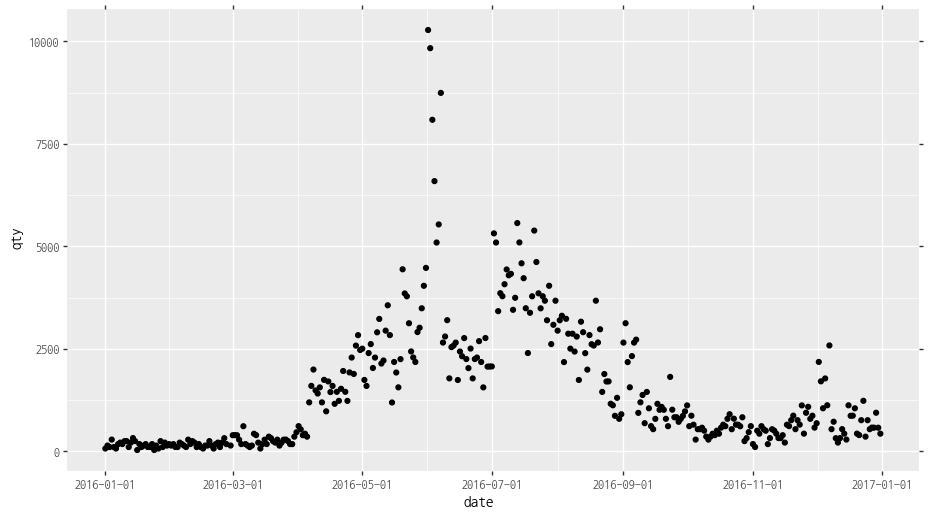

<ggplot: (151599109808)>

In [438]:
# 'date','temp','humid','wind','rain','snow','cloud'
# 제모제, 2016년, 시간(일)
(ggplot(dddwww.loc[dddwww['category']=='제모제'])
+ aes(x='date', y='qty')
+ geom_point()
+ theme(text=element_text(family='NanumGothicCoding'), figure_size = (11,6))
)

### 미세먼지, 건강, 데이트, 맛집, 취미
* social_pm
* social_health
* social_date
* social_br
* social_hobby

D:/project/contest/data/original/xxxxyyyyyzzzz.csv

In [355]:
social_pm = pd.read_csv('D:/project/contest/data/original/social_pm.csv',index_col=0, parse_dates=[1])
social_health = pd.read_csv('d:/project/contest/data/original/social_health.csv',index_col=0, parse_dates=[1])
social_date = pd.read_csv('d:/project/contest/data/original/social_date.csv',index_col=0, parse_dates=[1])
social_br = pd.read_csv('d:/project/contest/data/original/social_br.csv',index_col=0, parse_dates=[1])
social_hobby = pd.read_csv('d:/project/contest/data/original/social_hobby.csv',index_col=0, parse_dates=[1])

In [356]:
def changeColNames(d) : 
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace('social_',''))

In [357]:
social_pm.columns = changeColNames(social_pm)
social_health.columns = changeColNames(social_health)
social_date.columns = changeColNames(social_date)
social_br.columns = changeColNames(social_br)
social_hobby.columns = changeColNames(social_hobby)

In [358]:
collections = [social_pm, social_health, social_date, social_br, social_hobby]
len(collections)

5

In [359]:
dddwwwsss = dddwww.copy()
for df in collections:
    print(df.columns[1])
    dddwwwsss = dddwwwsss.merge(df, on='date',how='left')

pm.blog
health.blog
date.blog
br.blog
hobby.blog


In [362]:
dddwwwsss.tail(2)

,date,category,qty,temp,humid,wind,rain,snow,cloud,scaled,...,date.news,date.total,br.blog,br.twitter,br.news,br.total,hobby.blog,hobby.twitter,hobby.news,hobby.total
3657,2016-12-31,크림로션,9758,0.7,65.4,1.5,0.0,0.0,6.6,0.9758,...,91,3652,4303,1024,18,5345,700,2112,29,2841
3658,2016-12-31,훼이셜클렌저,7614,0.7,65.4,1.5,0.0,0.0,6.6,0.7614,...,91,3652,4303,1024,18,5345,700,2112,29,2841


In [363]:
dddwwwsss.columns

Index(['date', 'category', 'qty', 'temp', 'humid', 'wind', 'rain', 'snow',
       'cloud', 'scaled', 'pm.blog', 'pm.twitter', 'pm.news', 'pm.total',
       'health.blog', 'health.twitter', 'health.news', 'health.total',
       'date.blog', 'date.twitter', 'date.news', 'date.total', 'br.blog',
       'br.twitter', 'br.news', 'br.total', 'hobby.blog', 'hobby.twitter',
       'hobby.news', 'hobby.total'],
      dtype='object')

In [ ]:
dddwww

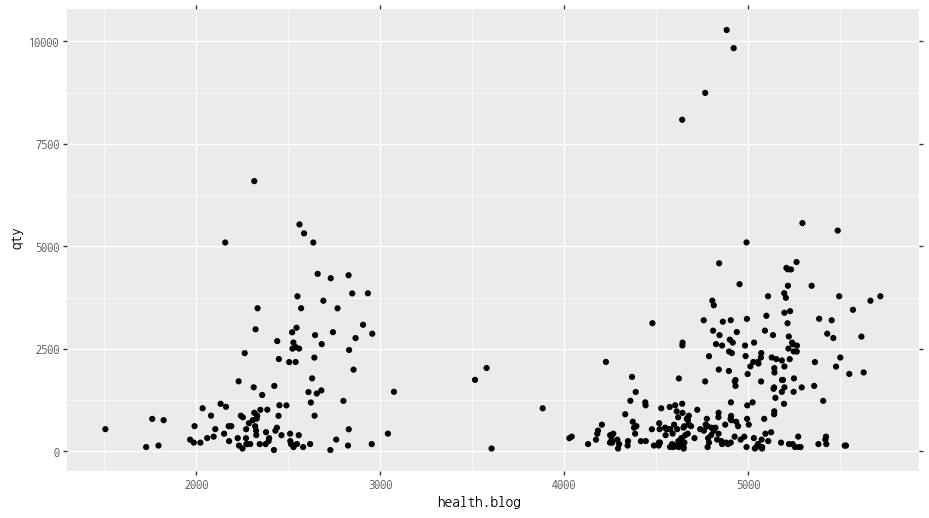

<ggplot: (-9223371885304555888)>

In [433]:
(ggplot(dddwwwsss.loc[dddwwwsss['category']=='제모제'])
+ aes(x='health.blog', y='qty')
+ geom_point()
+ theme(text=element_text(family='NanumGothicCoding'), figure_size = (11,6))
)

In [382]:
import seaborn as sns

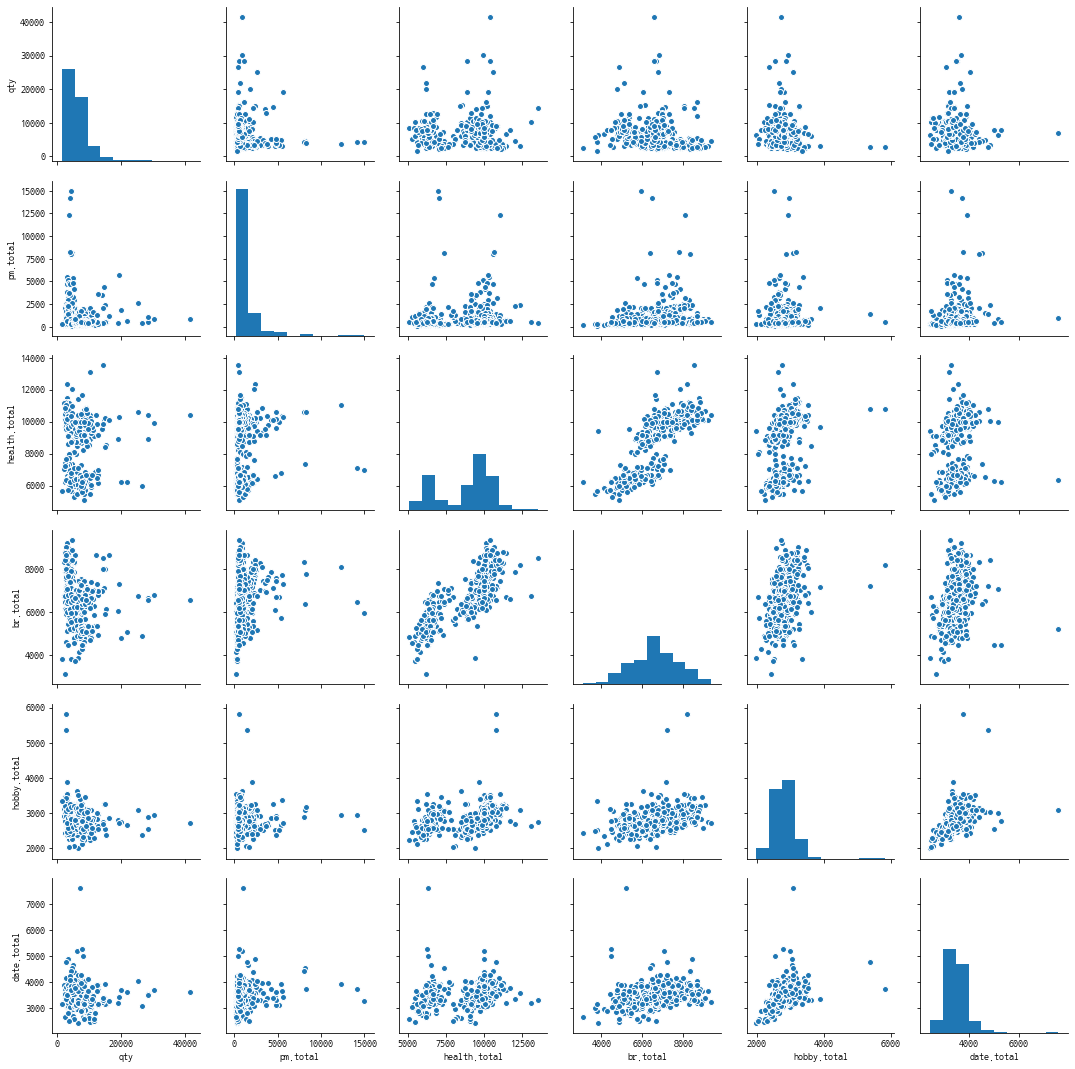

In [440]:
sns_cols = ['qty','pm.total', 'health.total','br.total', 'hobby.total','date.total']
sample = dddwwwsss.loc[dddwwwsss['category']=='바디로션',cols]
sns.pairplot(sample[cols])

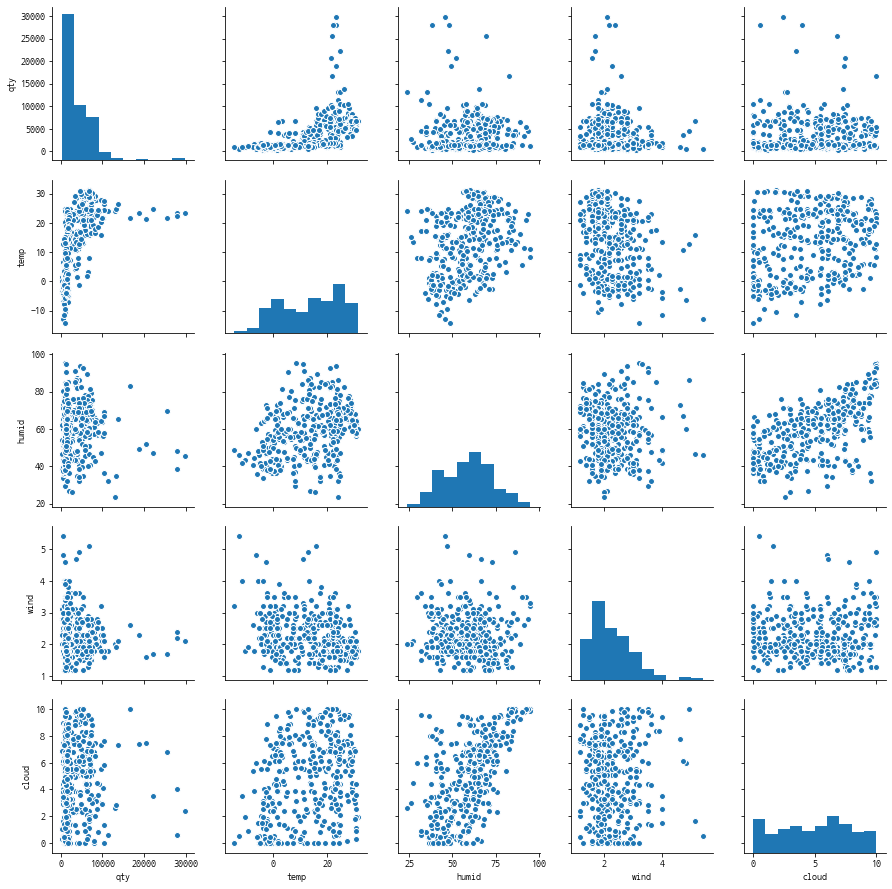

In [446]:
w_cols = ['qty', 'temp', 'humid', 'wind','cloud']
sample = dddwwwsss.loc[dddwwwsss['category']=='선케어',w_cols]
sns.pairplot(sample[w_cols])

In [397]:
import statsmodels.api as sm

In [396]:
logit = sm.Logit(data['Survived'], data[train_cols])

In [399]:
sample.head()

,qty,health.blog,health.twitter,health.news,health.total
7,1307,3606,5325,455,9386
17,1635,2825,3318,195,6338
27,2112,2581,3014,350,5945
37,1417,5422,3381,945,9748
47,1563,5257,3675,679,9611


In [425]:
train_cols = ['temp', 'humid', 'wind', 'rain', 'snow',
       'cloud', 'scaled', 'pm.blog', 'pm.twitter', 'pm.news', 'pm.total',
       'health.blog', 'health.twitter', 'health.news', 'health.total',
       'date.blog', 'date.twitter', 'date.news', 'date.total', 'br.blog',
       'br.twitter', 'br.news', 'br.total', 'hobby.blog', 'hobby.twitter',
       'hobby.news', 'hobby.total']
sample = dddwwwsss.loc[dddwwwsss['category']=='제모제']

In [426]:
sample.head(1)

,date,category,qty,temp,humid,wind,rain,snow,cloud,scaled,...,date.news,date.total,br.blog,br.twitter,br.news,br.total,hobby.blog,hobby.twitter,hobby.news,hobby.total
6,2016-01-01,제모제,72,1.2,73.0,1.6,0.0,0.0,7.0,0.0072,...,159,2427,3211,596,36,3843,621,1342,21,1984


In [427]:
sample_ans = sample['qty']
sample_data = sample.iloc[:,1:]

In [428]:
sample_data.head(2)

,category,qty,temp,humid,wind,rain,snow,cloud,scaled,pm.blog,...,date.news,date.total,br.blog,br.twitter,br.news,br.total,hobby.blog,hobby.twitter,hobby.news,hobby.total
6,제모제,72,1.2,73.0,1.6,0.0,0.0,7.0,0.0072,134,...,159,2427,3211,596,36,3843,621,1342,21,1984
16,제모제,145,5.7,76.9,2.0,0.0,0.0,7.8,0.0145,195,...,84,2777,4007,1063,35,5105,640,1694,28,2362


In [429]:
logit = sm.Logit(sample['qty'], sample[train_cols])
result = logit.fit(method = 'bfgs')
result.summary()

ValueError: endog must be in the unit interval.